In [1]:
%load_ext autoreload
%autoreload 2
import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')

import time
import torch
import cv2
import copy
from matplotlib import pyplot as plt
import numpy as np

from mitsuba.python.autodiff import render, render_torch, write_bitmap
from mitsuba.python.util import traverse
from mitsuba.core.xml import load_file
from mitsuba.core import Thread, Vector3f


from torch_openpose.body import Body
from torch_openpose import util

In [2]:
STRIDE = 8
PAD_VALUE = 128
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
ORIG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

body_estimation = Body(
    '/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Thread.thread().file_resolver().append('pose_scene')
scene = load_file('pose_scene/scene_no_texture.xml')

# Find differentiable scene parameters
params = traverse(scene)
print(params)

# Render a reference image (no derivatives used yet)
rendering_torch = render_torch(scene, spp=32)

# make torch RGB to BGR
PERMUTE_BGR = [2, 1, 0]
rendering_torch_BGR = rendering_torch[:, :, PERMUTE_BGR]
# permute and stack
rendering_torch_input = torch.stack([rendering_torch_BGR.permute((2, 0, 1))  - 0.5])

cuda:0


2020-03-31 14:42:06 INFO main [xml.cpp:1117] Loading XML file "pose_scene/scene_no_texture.xml" ..

2020-03-31 14:42:06 INFO main [xml.cpp:1118] Using variant "gpu_autodiff_rgb"

2020-03-31 14:42:06 INFO main [xml.cpp:348] "pose_scene/scene_no_texture.xml": in-memory version upgrade (v0.6.0 -> v2.0.0) ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/srgb.so" ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/uniform.so" ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/direct.so" ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/diffuse.so" ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/serialized.so" ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/obj.so" ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/constant.so" ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/independent.so" ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/box.so" ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/hdrfilm.so" ..

2020-03-31 14:42:06 INFO main [PluginManager] Loading plugin "plugins/perspective.so" ..

2020-03-31 14:42:06 INFO main [Scene] Validating and building scene in OptiX.

K=human.bsdf.reflectance.value
K=human.vertex_count
K=human.face_count
K=human.faces
K=human.vertex_positions
K=human.vertex_normals
K=human.vertex_texcoords
K=rect.bsdf.reflectance.value
K=rect.vertex_count
K=rect.face_count
K=rect.faces
K=rect.vertex_positions
K=rect.vertex_normals
K=rect.vertex_texcoords
K=ConstantBackgroundEmitter.radiance.value
K=PerspectiveCamera.near_clip
K=PerspectiveCamera.far_clip
K=PerspectiveCamera.focus_distance
K=PerspectiveCamera.shutter_open
K=PerspectiveCamera.shutter_open_time
ParameterMap[
  * human.bsdf.reflectance.value,
    human.vertex_count,
    human.face_count,
    human.faces,
  * human.vertex_positions,
  * human.vertex_normals,
  * human.vertex_texcoords,
  * rect.bsdf.reflectance.value,
    rect.vertex_count,
    rect.face_count,
    rect.faces,
  * rect.vertex_positions,
  * rect.vertex_normals,
  * rect.vertex_texcoords,
  * ConstantBackgroundEmitter.radiance.value,
    PerspectiveCamera.near_clip,
    PerspectiveCamera.far_clip,
    Per

In [5]:
diff_parameter = 'human.vertex_positions'
params.keep([diff_parameter])
params.update()
# Which parameters should be exposed to the PyTorch optimizer?
params_torch = params.torch()

print(params_torch)

{'human.vertex_positions': tensor([[-9.1756e+01,  1.3772e+02, -2.2231e+00],
        [-9.1221e+01,  1.3758e+02, -2.0400e+00],
        [-9.1033e+01,  1.3868e+02, -1.9917e+00],
        ...,
        [-7.2310e-01,  1.3888e+02,  1.8341e+01],
        [-4.4737e-01,  1.3901e+02,  1.7802e+01],
        [-1.0230e-01,  1.3673e+02,  1.6823e+01]], device='cuda:0',
       requires_grad=True)}


In [8]:
# Construct a PyTorch Adam optimizer that will adjust 'params_torch'
opt = torch.optim.Adam(params_torch.values(), lr=.2)
objective = torch.nn.MSELoss()

In [ ]:
joint_id = 4
# Zero out gradients before each iteration
opt.zero_grad()

# render image
cur_rednering_torch = render_torch(scene, params=params, unbiased=True, spp=16, **params_torch)

# transform from rgb to bgr
PERMUTE_BGR = [2, 1, 0]
rendering_torch_BGR = cur_rednering_torch[:, :, PERMUTE_BGR]

# permute channels to pytorch order and stack
rendering_torch_input = torch.stack([rendering_torch_BGR.permute((2, 0, 1))  - 0.5])

# compute the avg heatmap and paf map
paf, heatmap = body_estimation.model(rendering_torch_input)

# get the joint heatmap of the joint id
joint_heatmap = heatmap[0, joint_id]


single_zero_heatmap = torch.zeros((46, 54), device=device)
ob_val = objective(joint_heatmap, single_zero_heatmap)
print(ob_val)
ob_val.backward()

print(params_torch[diff_parameter].grad)


In [17]:
time_a = time.time()

iterations = 100
for it in range(iterations):
    # Zero out gradients before each iteration
    opt.zero_grad()

    # Perform a differentiable rendering of the scene
    image = render_torch(scene, params=params, unbiased=True,
                         spp=4, **params_torch)


    # Objective: MSE between 'image' and 'image_ref'
    ob_val = objective(image, rendering_torch)

    # Back-propagate errors to input parameters
    ob_val.backward()

    # Optimizer: take a gradient step
    opt.step()

    # Compare iterate against ground-truth value
    err_ref = objective(params_torch[diff_parameter], param_ref)
    print('Iteration %03i: error=%g' % (it, err_ref), end='\r')

time_b = time.time()

print()
print('%f ms per iteration' % (((time_b - time_a) * 1000) / iterations))

Iteration 099: error=2.03792
34.053559 ms per iteration


(-0.5, 431.5, 367.5, -0.5)

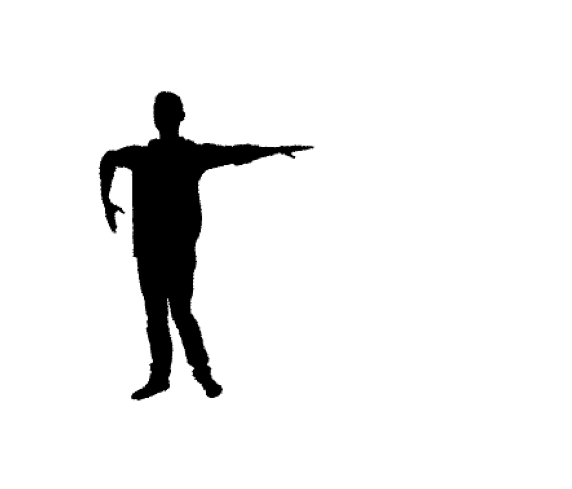

In [18]:
canvas = image.cpu().detach().numpy()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(canvas[:, :, [2, 1, 0]])
ax.axis('off')